# Evaluation of CosmoFlow training

In [ ]:
import os
import sys
import yaml

sys.path.append('..')

In [24]:
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [25]:
from models import get_model
from data.cosmo import construct_dataset

from utils.optimizers import get_optimizer

In [26]:
%matplotlib inline

## Load configuration

In [27]:
def load_config(config_file):
    """Reads the YAML config file and returns a config dictionary"""
    with open(config_file) as f:
        return yaml.load(f, Loader=yaml.FullLoader)

In [28]:
config_file = '../configs/cosmo.yaml'

In [29]:
config = load_config(config_file)

In [30]:
config

{'output_dir': '$SCRATCH/cosmoflow-benchmark/cosmoflow-${SLURM_JOB_ID}',
 'data': {'name': 'cosmo',
  'data_dir': '/project/projectdirs/m3363/www/cosmoUniverse_2018_10_3parA/dim128_cube',
  'n_train_files': 2048,
  'n_valid_files': 1024,
  'samples_per_file': 16,
  'batch_size': 4,
  'n_epochs': 16},
 'model': {'name': 'cosmoflow',
  'input_shape': [128, 128, 128, 1],
  'target_size': 3,
  'dropout': 0.2},
 'optimizer': {'name': 'Adam', 'lr': 0.001},
 'train': {'loss': 'mse', 'metrics': ['mae']}}

## Reload the model

In [31]:
def load_history(result_dir):
    with np.load(os.path.join(result_dir, 'history.npz')) as f:
        return dict(f.items())

In [32]:
ls /global/cscratch1/sd/sfarrell/cosmoflow-benchmark

cosmoflow-154846/  cosmoflow-155912/  cosmoflow-157761/  cosmoflow-158130/
cosmoflow-154858/  cosmoflow-155987/  cosmoflow-158072/
cosmoflow-154996/  cosmoflow-156746/  cosmoflow-158127/


In [33]:
ls -l /global/cscratch1/sd/sfarrell/cosmoflow-benchmark/cosmoflow-158130

total 338056
-rw-rw---- 1 sfarrell sfarrell      229 Jun 10 20:27 checkpoint
-rw-rw---- 1 sfarrell sfarrell 21630571 Jun 10 16:44 checkpoint-001.ckpt.data-00000-of-00001
-rw-rw---- 1 sfarrell sfarrell     2113 Jun 10 16:44 checkpoint-001.ckpt.index
-rw-rw---- 1 sfarrell sfarrell 21630571 Jun 10 16:59 checkpoint-002.ckpt.data-00000-of-00001
-rw-rw---- 1 sfarrell sfarrell     2113 Jun 10 16:59 checkpoint-002.ckpt.index
-rw-rw---- 1 sfarrell sfarrell 21630571 Jun 10 17:14 checkpoint-003.ckpt.data-00000-of-00001
-rw-rw---- 1 sfarrell sfarrell     2113 Jun 10 17:14 checkpoint-003.ckpt.index
-rw-rw---- 1 sfarrell sfarrell 21630571 Jun 10 17:29 checkpoint-004.ckpt.data-00000-of-00001
-rw-rw---- 1 sfarrell sfarrell     2113 Jun 10 17:29 checkpoint-004.ckpt.index
-rw-rw---- 1 sfarrell sfarrell 21630571 Jun 10 17:44 checkpoint-005.ckpt.data-00000-of-00001
-rw-rw---- 1 sfarrell sfarrell     2113 Jun 10 17:44 checkpoint-005.ckpt.index
-rw-rw---- 1 sfarrell sfarrell 21630571 Jun 10 17:59 checkpoint

In [38]:
result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/cosmoflow-158130'

In [39]:
checkpoint = tf.train.latest_checkpoint(result_dir)
train_history = load_history(result_dir)

In [56]:
model = get_model(**config['model'])
opt = get_optimizer(**config['optimizer'])
train_config = config['train']
model.compile(optimizer=opt, loss=train_config['loss'],
              metrics=train_config['metrics'])
model.load_weights(checkpoint)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 128, 128, 128, 16) 448       
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 64, 64, 64, 16)    0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 64, 64, 64, 32)    13856     
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 32, 32, 32, 32)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 32, 32, 32, 64)    55360     
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 16, 16, 16, 64)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 16, 16, 16, 128)   221312    
__________

## Training curves

In [41]:
train_history

{'loss': array([0.77503252, 0.21947198, 0.20269092, 0.18633516, 0.17863605,
        0.17234665, 0.16785637, 0.16632762, 0.16429005, 0.16247181,
        0.16231355, 0.16129797, 0.16132228, 0.16001291, 0.16058202,
        0.16076552]),
 'mean_absolute_error': array([0.4479443 , 0.38069832, 0.3632981 , 0.34590796, 0.33706483,
        0.3296048 , 0.32446337, 0.32282105, 0.3202646 , 0.3178829 ,
        0.31790033, 0.31641406, 0.31679425, 0.3157577 , 0.31632072,
        0.31659412], dtype=float32),
 'val_loss': array([0.20986191, 0.20820936, 0.21547477, 0.1779739 , 0.17661815,
        0.16166304, 0.15745507, 0.15609657, 0.15756116, 0.18184861,
        0.1533646 , 0.16039522, 0.17542837, 0.15565411, 0.14667371,
        0.15119632]),
 'val_mean_absolute_error': array([0.37288907, 0.3658281 , 0.36718243, 0.3350679 , 0.33229503,
        0.3214555 , 0.3110418 , 0.3117853 , 0.31277043, 0.333522  ,
        0.30712053, 0.31872115, 0.34384993, 0.30684963, 0.2977104 ,
        0.30605048], dtype=float3

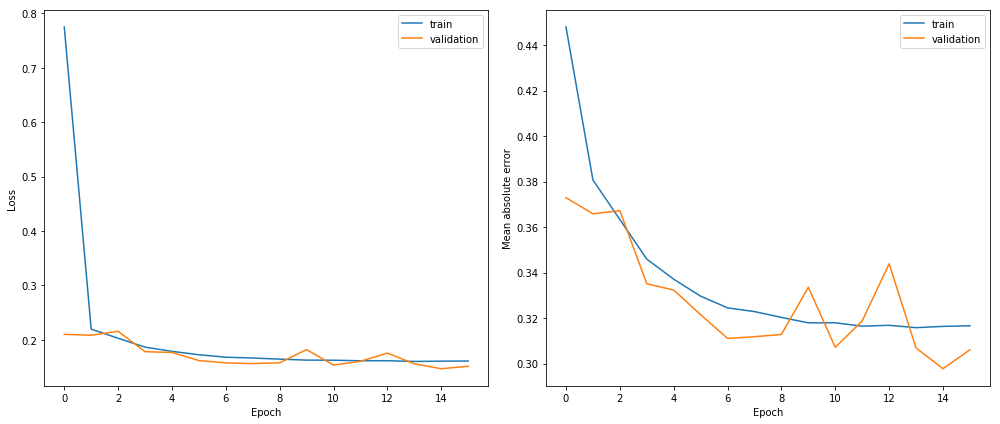

In [42]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

ax0.plot(train_history['loss'], label='train')
ax0.plot(train_history['val_loss'], label='validation')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(train_history['mean_absolute_error'], label='train')
ax1.plot(train_history['val_mean_absolute_error'], label='validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean absolute error')
ax1.legend(loc=0)

plt.tight_layout()

## Load a test set

In [43]:
data_config = config['data']
data_dir = data_config['data_dir']

In [44]:
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)
             if f.endswith('tfrecords')]

In [52]:
n_test_files = 4

n_test = n_test_files * data_config['samples_per_file']

In [53]:
test_files = all_files[-n_test_files:]
test_data = construct_dataset(test_files, batch_size=1, n_epochs=1)

In [ ]:
model.evaluate(test_data, steps=n_test)

## Discussion

Currently it seems the 3D CNN model is merely learning the average answer.
Let's trying running larger scale.